In [33]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from scipy.sparse import hstack, coo_matrix
from scipy.sparse import save_npz, load_npz
from sklearn.preprocessing import MaxAbsScaler
from sklearn.externals import joblib
from sklearn.model_selection import train_test_split

from sklearn.manifold import TSNE
from sklearn.decomposition import TruncatedSVD

import hdbscan

import pickle as pic

In [2]:
class_names = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

train = pd.read_csv('inputs/train.csv').fillna(' ')
test = pd.read_csv('inputs/test.csv').fillna(' ')

train_text = train['comment_text']
test_text = test['comment_text']
all_text = pd.concat([train_text, test_text])

In [15]:
print(list(train.columns.values))

['id', 'comment_text', 'toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']


In [3]:
train.shape

(95851, 8)

In [6]:
word_vectorizer = TfidfVectorizer(
    sublinear_tf=True,
    strip_accents='unicode',
    analyzer='word',
    token_pattern=r'\w{1,}',
    stop_words='english',
    ngram_range=(1, 1),
    max_features=10000)
word_vectorizer.fit(all_text)
train_word_features = word_vectorizer.transform(train_text)
test_word_features = word_vectorizer.transform(test_text)
print('unigrams Done')


char_vectorizer = TfidfVectorizer(
    sublinear_tf=True,
    strip_accents='unicode',
    analyzer='char',
    stop_words='english',
    ngram_range=(2, 6),
    max_features=20000)
char_vectorizer.fit(all_text)
train_char_features = char_vectorizer.transform(train_text)
test_char_features = char_vectorizer.transform(test_text)
print('ngrams done')

unigrams Done
ngrams done


In [9]:
pic.dump( word_vectorizer, open( "word_vectorizer.p", "wb" ) )
pic.dump( train_word_features, open( "train_word_features.p", "wb" ) )
pic.dump( test_word_features, open( "test_word_features.p", "wb" ) )


pic.dump( char_vectorizer, open( "char_vectorizer.p", "wb" ) )
pic.dump( train_char_features, open( "train_char_features.p", "wb" ) )
pic.dump( test_char_features, open( "test_char_features.p", "wb" ) )

In [5]:
word_vectorizer = pic.load( open( "word_vectorizer.p", "rb" ) )
train_word_features = pic.load( open( "train_word_features.p", "rb" ) )
test_word_features = pic.load( open( "test_word_features.p", "rb" ) )

char_vectorizer = pic.load( open( "char_vectorizer.p", "rb" ) )
train_char_features = pic.load( open( "train_char_features.p", "rb" ) )
test_char_features = pic.load( open( "test_char_features.p", "rb" ) )

In [11]:
tsvd = TruncatedSVD(n_components=50,random_state=0)
reduc1 = tsvd.fit_transform(train_word_features.todense())

In [12]:
tsne_model = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='random') #n_iter_without_progress
#projection = tsne_model.fit_transform(tf_matrix.todense())
projection = tsne_model.fit_transform(reduc1)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 95851 samples in 0.627s...
[t-SNE] Computed neighbors for 95851 samples in 1359.358s...
[t-SNE] Computed conditional probabilities for sample 1000 / 95851
[t-SNE] Computed conditional probabilities for sample 2000 / 95851
[t-SNE] Computed conditional probabilities for sample 3000 / 95851
[t-SNE] Computed conditional probabilities for sample 4000 / 95851
[t-SNE] Computed conditional probabilities for sample 5000 / 95851
[t-SNE] Computed conditional probabilities for sample 6000 / 95851
[t-SNE] Computed conditional probabilities for sample 7000 / 95851
[t-SNE] Computed conditional probabilities for sample 8000 / 95851
[t-SNE] Computed conditional probabilities for sample 9000 / 95851
[t-SNE] Computed conditional probabilities for sample 10000 / 95851
[t-SNE] Computed conditional probabilities for sample 11000 / 95851
[t-SNE] Computed conditional probabilities for sample 12000 / 95851
[t-SNE] Computed conditional probabilities for 

In [13]:
pic.dump( tsvd, open( "tsvd.p", "wb" ) )
pic.dump( reduc1, open( "reduc1.p", "wb" ) )

pic.dump( tsne_model, open( "tsne_model.p", "wb" ) )
pic.dump( projection, open( "projection.p", "wb" ) )

In [6]:
tsvd = pic.load( open( "tsvd.p", "rb" ) )
reduc1 = pic.load( open( "reduc1.p", "rb" ) )
tsne_model = pic.load( open( "tsne_model.p", "rb" ) )
projection = pic.load( open( "projection.p", "rb" ) )

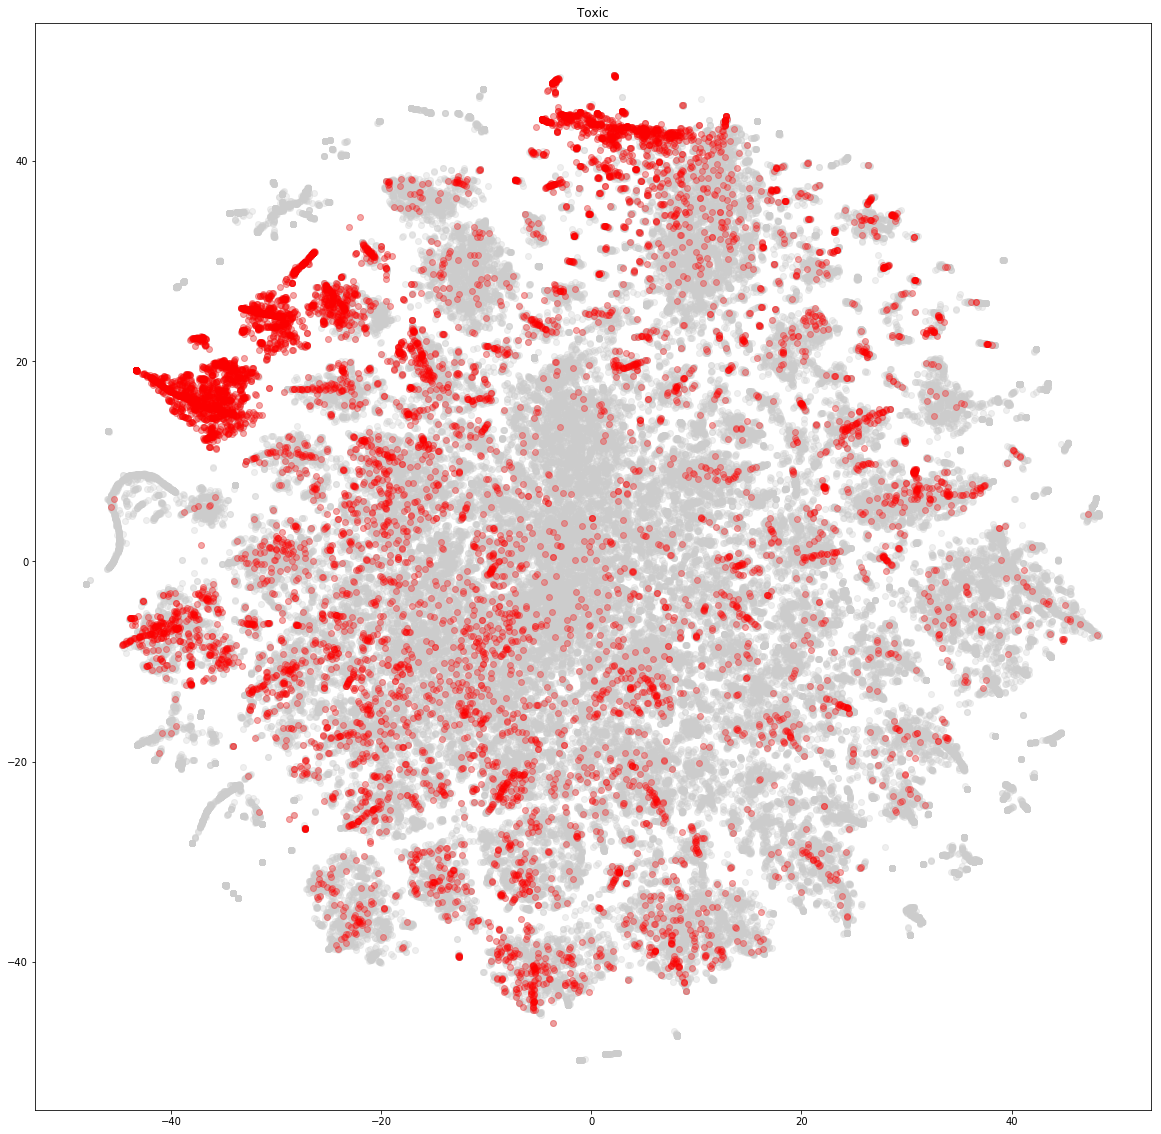

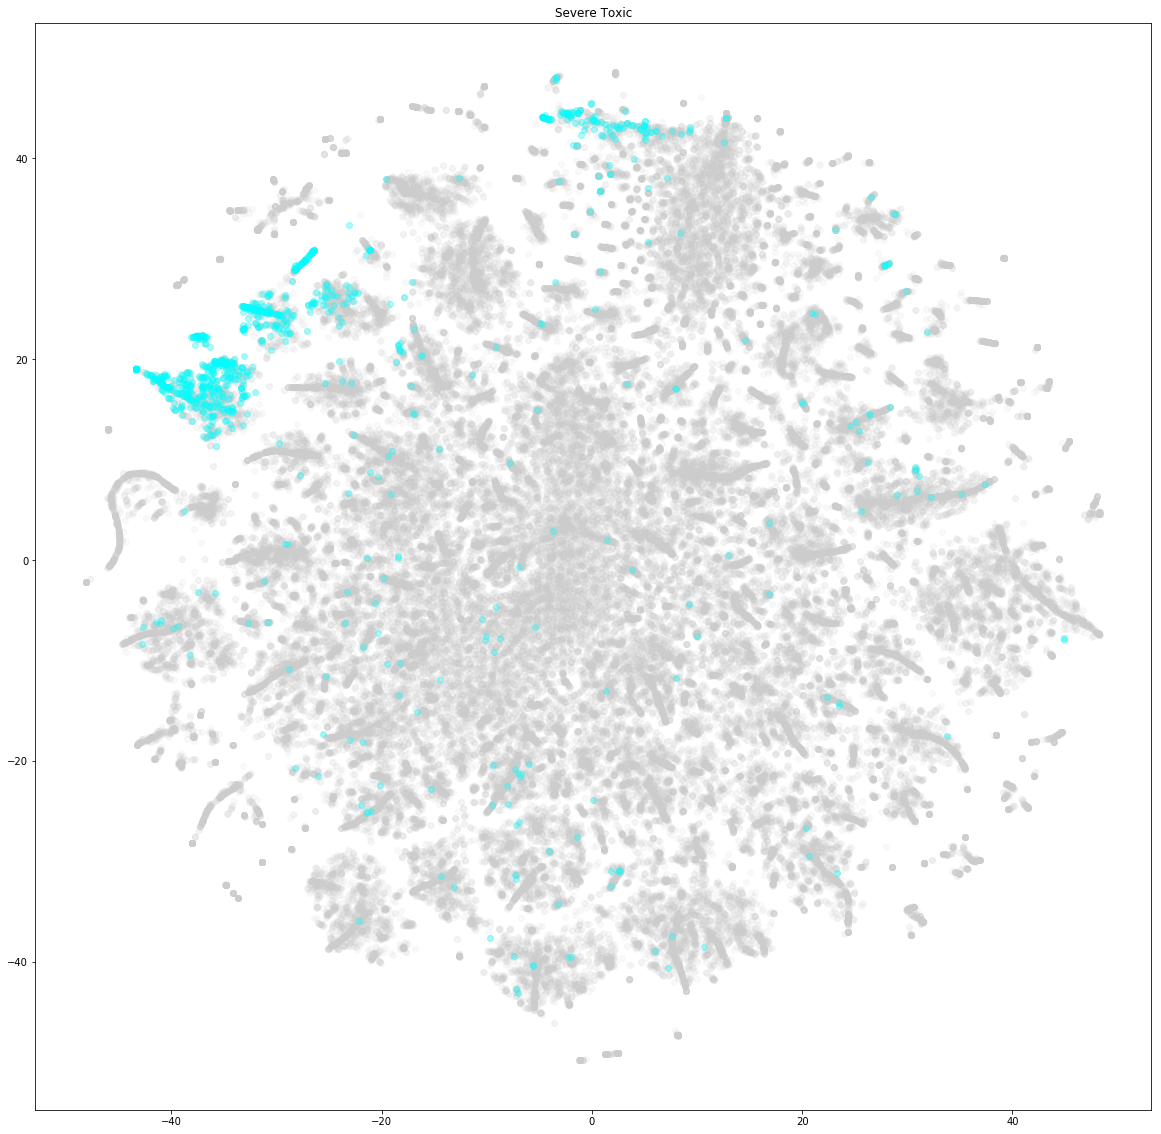

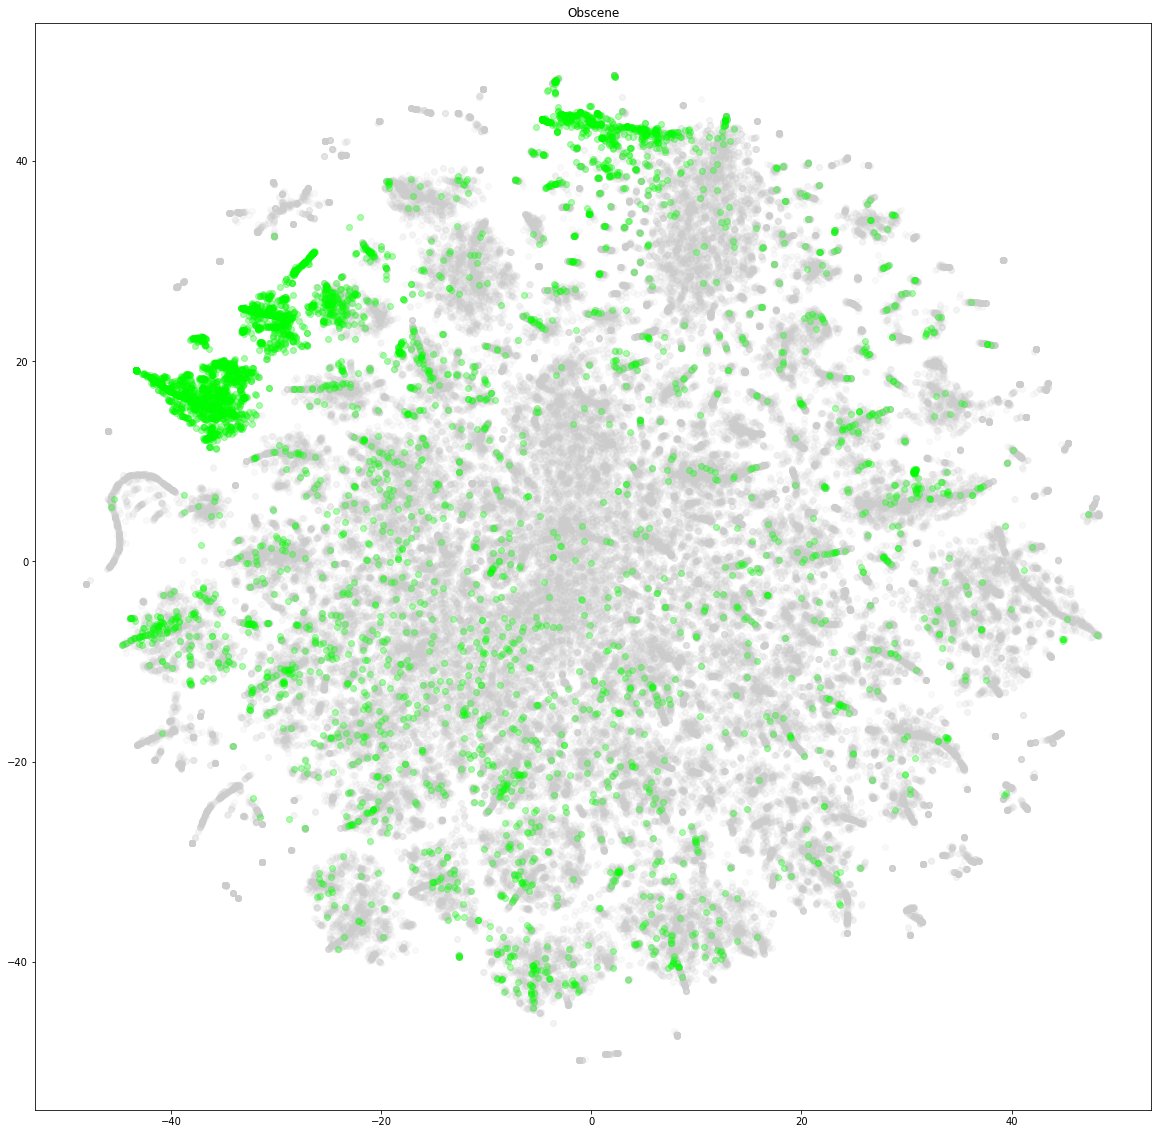

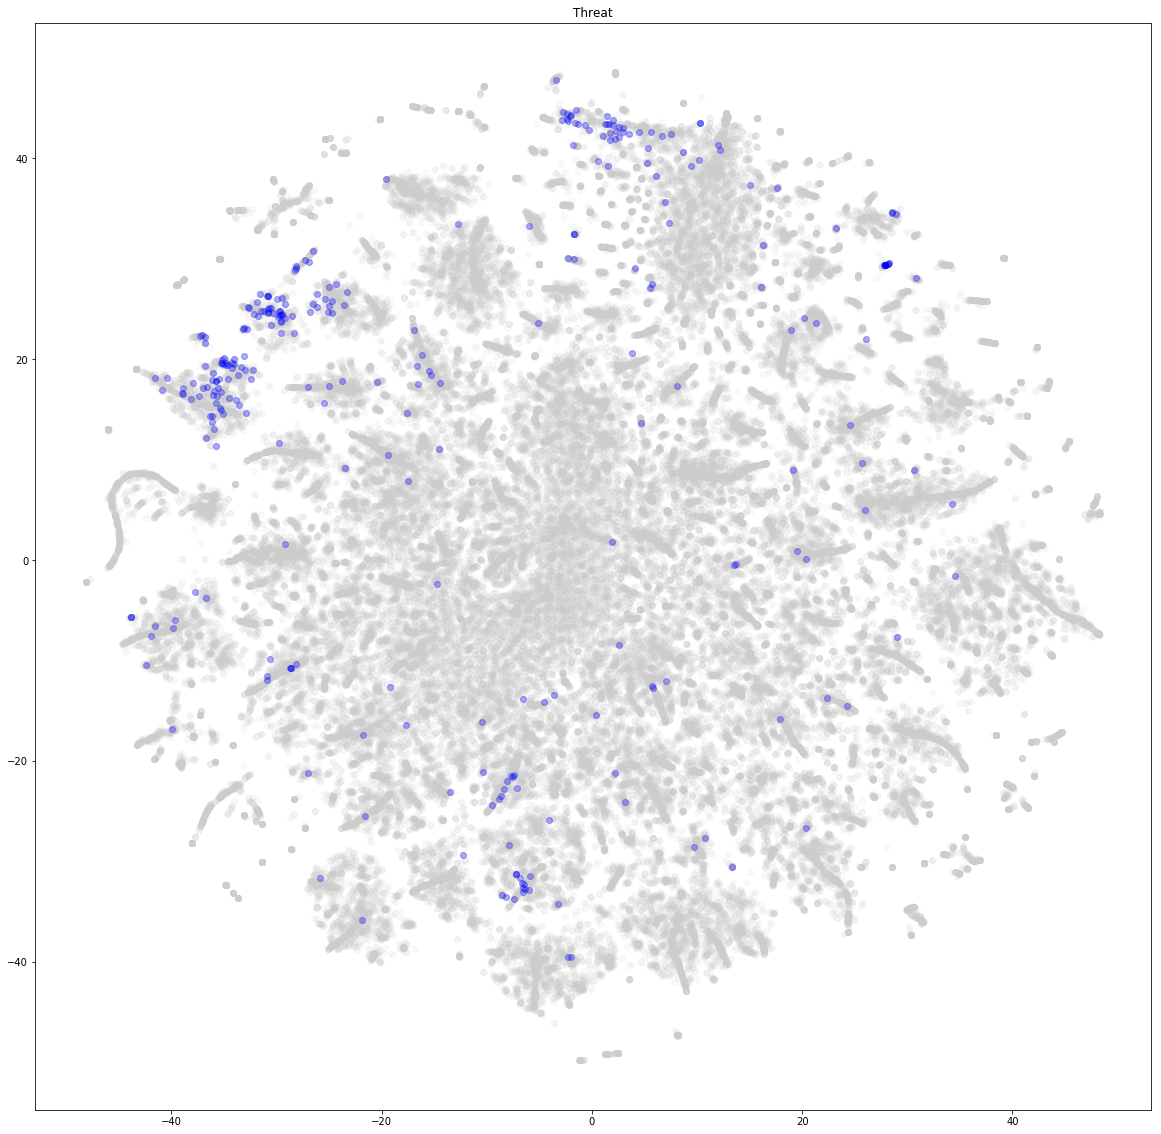

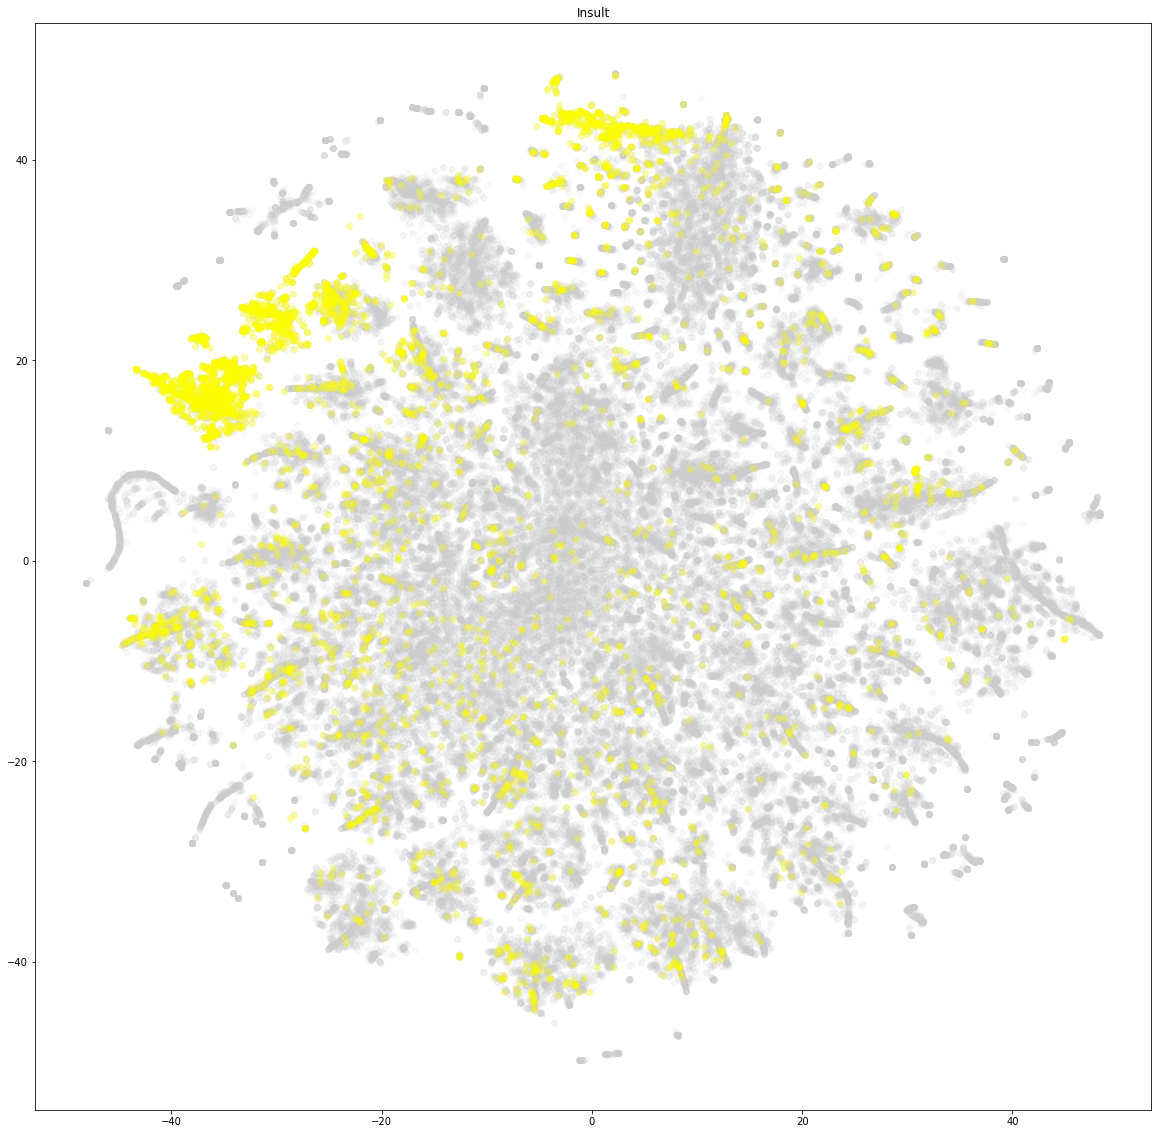

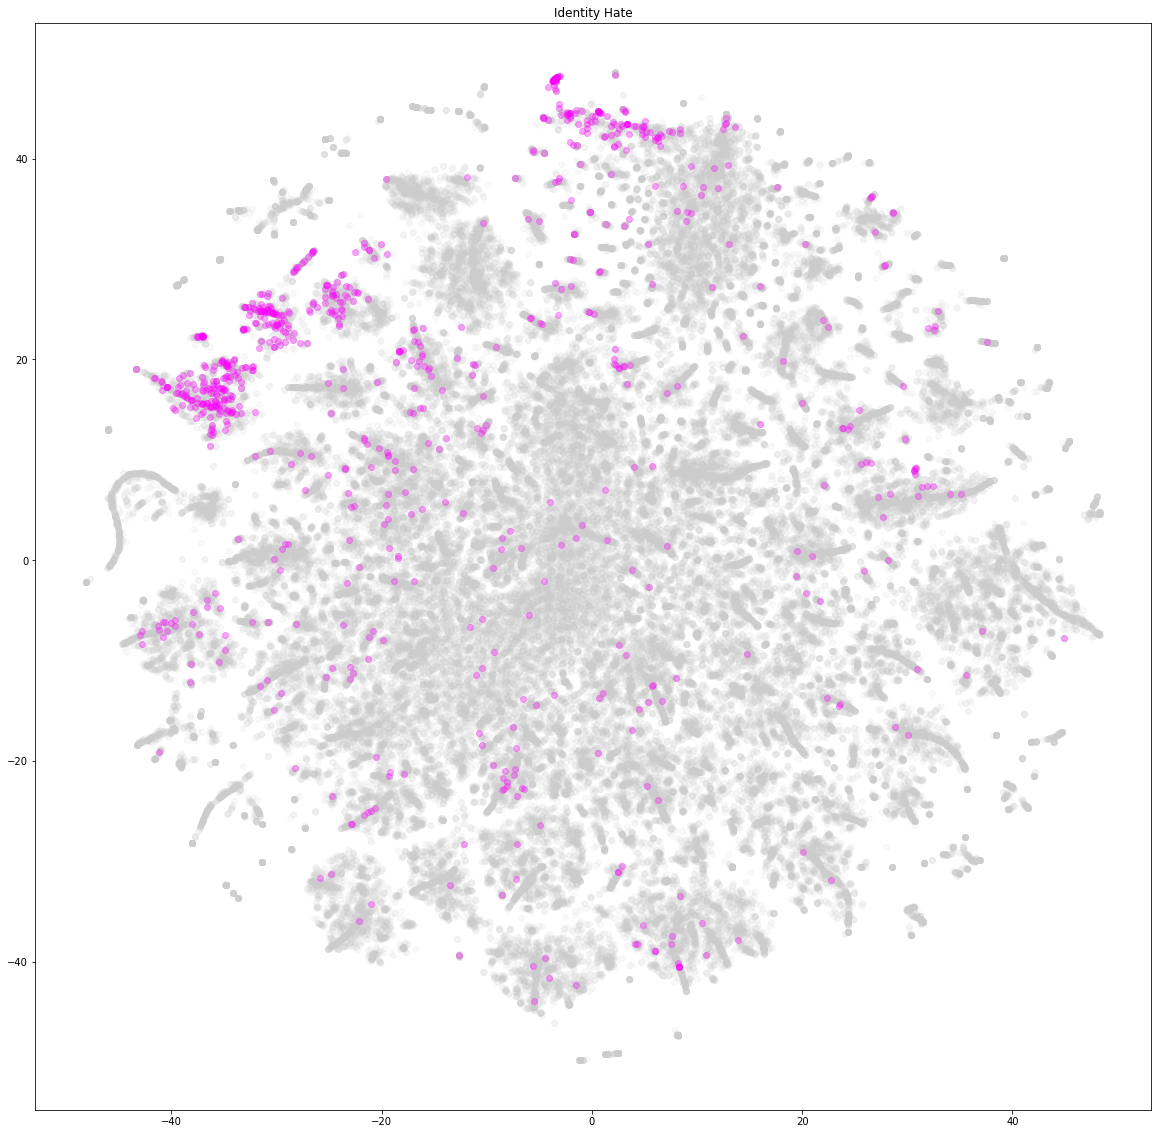

In [31]:
fig = plt.figure(figsize = (20, 20))
ax = plt.axes()
color_palette = sns.color_palette("hls",7)
plt.scatter(projection[:, 0], projection[:, 1],color=(0.8,0.8,0.8,0.3))

# 'comment_text', 'toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate'

#toxic
toxic = train.toxic ==1
severe_toxic = train.severe_toxic ==1
plt.title("Toxic")
plt.scatter(projection[toxic, 0], projection[toxic, 1],color=(1,0,0,0.3))
plt.show()

# 1.5
fig = plt.figure(figsize = (20, 20))
ax = plt.axes()
plt.scatter(projection[:, 0], projection[:, 1],color=(0.8,0.8,0.8,0.1))
plt.title("Severe Toxic")
plt.scatter(projection[severe_toxic, 0], projection[severe_toxic, 1],color=(0,1,1,0.3))
plt.show()

# 2

fig = plt.figure(figsize = (20, 20))
ax = plt.axes()
plt.scatter(projection[:, 0], projection[:, 1],color=(0.8,0.8,0.8,0.1))
plt.title("Obscene")
obscene = train.obscene ==1
plt.scatter(projection[obscene, 0], projection[obscene, 1],color=(0,1,0,0.3))

#3 

fig = plt.figure(figsize = (20, 20))
ax = plt.axes()
plt.scatter(projection[:, 0], projection[:, 1],color=(0.8,0.8,0.8,0.1))
plt.title("Threat")
threat = train.threat ==1
plt.scatter(projection[threat, 0], projection[threat, 1],color=(0,0,1,0.3))

# 4

fig = plt.figure(figsize = (20, 20))
ax = plt.axes()
plt.scatter(projection[:, 0], projection[:, 1],color=(0.8,0.8,0.8,0.1))
plt.title("Insult")
insult = train.insult ==1
plt.scatter(projection[insult, 0], projection[insult, 1],color=(1,1,0,0.3))

# 5
fig = plt.figure(figsize = (20, 20))
ax = plt.axes()
plt.scatter(projection[:, 0], projection[:, 1],color=(0.8,0.8,0.8,0.1))
plt.title("Identity Hate")
identity_hate = train.identity_hate ==1
plt.scatter(projection[identity_hate, 0], projection[identity_hate, 1],color=(1,0,1,0.3))


#ax.legend([i for i in np.unique(hdb.labels_)])
#plt.text(4, 1, , ha='left', rotation=15, wrap=True)


In [48]:
feature_array = np.array(word_vectorizer.get_feature_names())
indices = np.argsort(word_vectorizer.idf_)[::-1]
top_n = 50
top_features = [feature_array[i] for i in indices[:top_n]]
print(top_features)

['pneis', 'aidsaids', 'thisthisthisthisthisthis', 'fucksex', 'gayfrozen', 'tajin', 'pensnsnniensnsn', 'haahhahahah', 'pennnis', 'hahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahaha', 'pagedelete', 'itsuck', 'youbollocks', 'پیش', 'kanker', 'offfuck', 'kkkkkk', 'securityfuck', '_extinct_animalshttp', '55555', 'maquedaall', 'marcolfuck', 'shitfuck', 'sexsex', 'yaaaa', 'bunksteve', 'bitchmattythewhite', 'تعیین', 'biznitch', 'bleachanhero', 'boymamas', 'اثرات', 'deneid', 'centraliststupid', 'cheesei', 'شده', 'zoo_tycoon_2', 'ancestryfuck', 'concernthanks', 'coolkevin', 'criminalwar', 'قوانین', 'cuntliz', 'bastered', 'mangina', 'equiv', 'lawdy', 'chocobos', 'cuntfranks', 'fack']


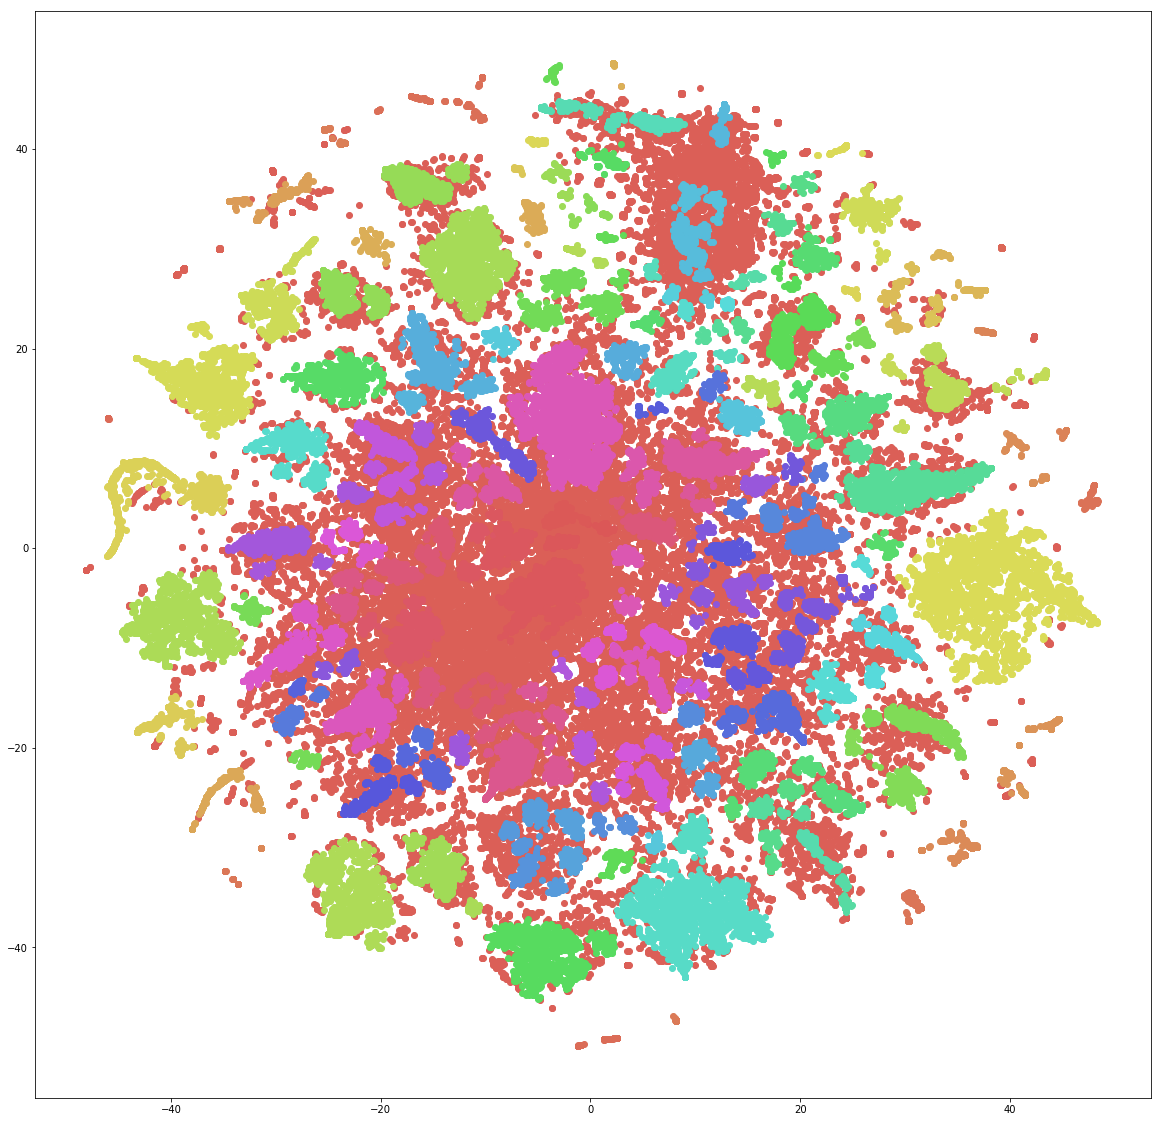

In [39]:
hdb = hdbscan.HDBSCAN(min_cluster_size=50)
#clusterer.fit(tf_matrix)
hdb.fit(projection)

#for clust in np.unique(hdb.labels_):
#    idx = hdb.labels_ == clust
#    df_c = df.body_html.loc[idx]
#    tfidfc = TfidfVectorizer(tokenizer=tokenize,min_df=0.03,stop_words='english',sublinear_tf=True,norm="l2")
#    response = tfidfc.fit_transform(df_c)
#    feature_array = np.array(tfidfc.get_feature_names())
#    tfidf_sorting = np.argsort(response.toarray()).flatten()[::-1]
#    n = 5
#    top_n = feature_array[tfidf_sorting][:n]
#    print("Cluster {0} top terms by IDF:{1}".format(clust,top_n))

#plot for HDBScan
fig = plt.figure(figsize = (20, 20))
ax = plt.axes()
color_palette = sns.color_palette("hls", len(np.unique(hdb.labels_))+1)
cluster_colors = [color_palette[x] if x >= 0
                  else (0.5, 0.5, 0.5)
                  for x in hdb.labels_]
for clust in np.unique(hdb.labels_):
    idx = clust==hdb.labels_
    plt.scatter(projection[idx, 0], projection[idx, 1], c = color_palette[clust+1],label=clust)
#ax.legend([i for i in np.unique(hdb.labels_)])
plt.show()